In [2]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import joblib
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

In [220]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. Configuration & File Paths
# ───────────────────────────────────────────────────────────────────────────────
DL_SHP       = "Te_ppm_DL_S_SOWETO.shp"
ORIG_SHP     = "Te_ppm_Orig_S_SOWETO.shp"
DL_PARQ      = "Te_ppm_DL_S_SOWETO.parquet"
ORIG_PARQ    = "Te_ppm_Orig_S_SOWETO.parquet"
TREE_DL_JOB  = "dl_tree.joblib"
TREE_ORIG_JOB= "orig_tree.joblib"

# Target projected CRS for metre-based distances (e.g. UTM 35S)
TARGET_CRS = "EPSG:3577"

In [100]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Parquet Conversion (one-time)
# ───────────────────────────────────────────────────────────────────────────────
def ensure_parquet(shp_fp, parq_fp):
    if not os.path.exists(parq_fp):
        print(f"Converting {os.path.basename(shp_fp)} → Parquet…")
        gdf = gpd.read_file(shp_fp)
        gdf.to_parquet(parq_fp, index=False)

for shp, parq in [(DL_SHP, DL_PARQ), (ORIG_SHP, ORIG_PARQ)]:
    ensure_parquet(shp, parq)

In [170]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. Load & Filter
# ───────────────────────────────────────────────────────────────────────────────
def load_gdf(parq_fp):
    gdf = gpd.read_parquet(parq_fp)         # fast columnar read
    gdf = gdf[gdf['Te_ppm'] > 0]             # drop non-positive
    return gdf.to_crs(TARGET_CRS)           # project to metres

dl_gdf   = load_gdf(DL_PARQ)
orig_gdf = load_gdf(ORIG_PARQ)

In [174]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. KD-Tree Caching
# ───────────────────────────────────────────────────────────────────────────────
def get_tree(gdf, cache_fp):
    if os.path.exists(cache_fp):
        return joblib.load(cache_fp)
    pts = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
    tree = cKDTree(pts)
    joblib.dump(tree, cache_fp)
    return tree

dl_tree   = get_tree(dl_gdf,   TREE_DL_JOB)
orig_tree = get_tree(orig_gdf, TREE_ORIG_JOB)

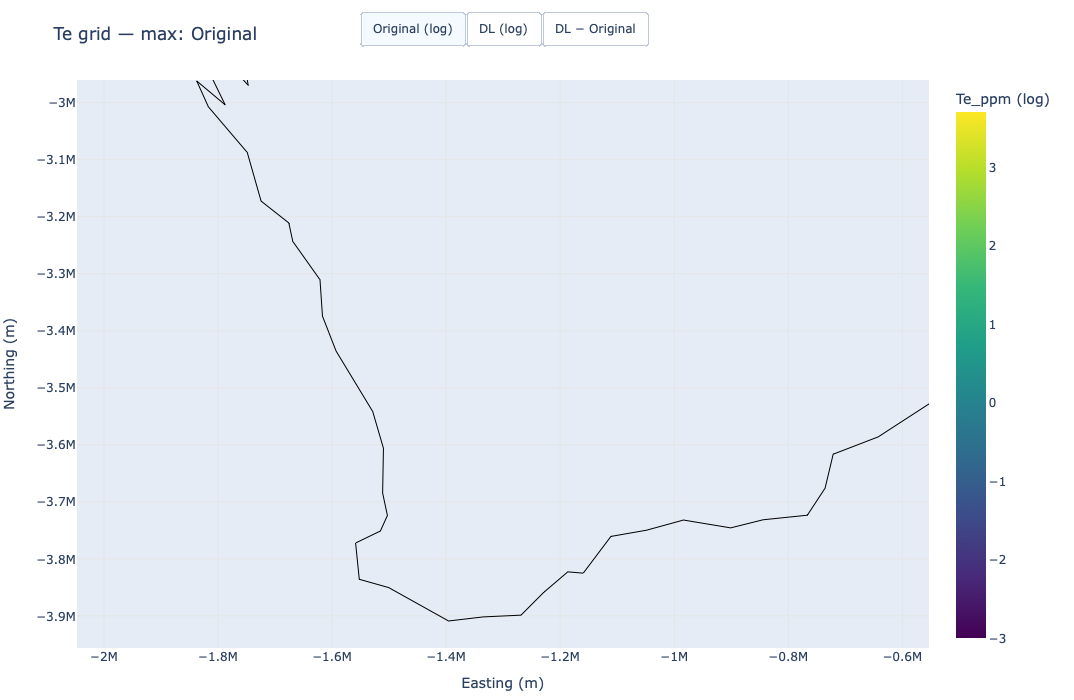

In [310]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. Grid comparison (Plotly map-like with Australia outline) + CSV export
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np
import geopandas as gpd
import plotly.graph_objects as go
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
import pandas as pd

# ---------- 5.1 Grid setup ----------
GRID_SPACING = 50000  # metres (edit to change cell size)

# Ensure projected CRS (metres)
orig_gdf = orig_gdf.to_crs(TARGET_CRS)
dl_gdf   = dl_gdf.to_crs(TARGET_CRS)

# Extent from data (with 5% padding)
minx1, miny1, maxx1, maxy1 = dl_gdf.total_bounds
minx2, miny2, maxx2, maxy2 = orig_gdf.total_bounds
minx, miny = min(minx1, minx2), min(miny1, miny2)
maxx, maxy = max(maxx1, maxx2), max(maxy1, maxy2)
pad_x, pad_y = 0.05 * (maxx - minx), 0.05 * (maxy - miny)
x0, x1, y0, y1 = minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y
extent = [x0, x1, y0, y1]

nx = int(np.ceil((x1 - x0) / GRID_SPACING))
ny = int(np.ceil((y1 - y0) / GRID_SPACING))

def assign_grid_indices(gdf, x0, y0, spacing, nx, ny):
    g = gdf.copy()
    g["grid_ix"] = ((g.geometry.x - x0) // spacing).astype(int).clip(0, nx - 1)
    g["grid_iy"] = ((g.geometry.y - y0) // spacing).astype(int).clip(0, ny - 1)
    return g

dl_idx   = assign_grid_indices(dl_gdf,   x0, y0, GRID_SPACING, nx, ny)
orig_idx = assign_grid_indices(orig_gdf, x0, y0, GRID_SPACING, nx, ny)

# ---------- 5.2 Compare (choose method) ----------
method_name = "max"  # "max" | "mean" | "median" | "chi2"
compare_fn  = COMPARISON_METHODS[method_name]
arr_orig, arr_dl, arr_cmp = compare_fn(dl_idx, orig_idx, nx, ny)  # (ny, nx)

is_chi2 = (method_name.lower() == "chi2")
orig_title = "Sample count (log)" if is_chi2 else "Te_ppm (log)"
diff_title = "χ² statistic" if is_chi2 else "Δ Te_ppm"



# ---------- 5.3 Australia boundary ----------
countries = gpd.read_file("ne_110m_admin_0_countries.shp")
australia = countries[countries["ADMIN"] == "Australia"].to_crs(TARGET_CRS)

# ---------- helpers ----------
def mask_nonpos(a):
    a = np.array(a, dtype=float)
    a[~np.isfinite(a) | (a <= 0)] = np.nan
    return a

def grid_centers_from_extent(extent, nx, ny):
    x0, x1, y0, y1 = extent
    dx = (x1 - x0) / nx
    dy = (y1 - y0) / ny
    xs = x0 + (np.arange(nx) + 0.5) * dx
    ys = y0 + (np.arange(ny) + 0.5) * dy
    return xs, ys

def gdf_to_line_traces(gdf, name="Boundary", color="black"):
    traces = []
    for geom in gdf.geometry:
        if geom is None:
            continue
        if isinstance(geom, Polygon):
            geoms = [geom.exterior]
        elif isinstance(geom, MultiPolygon):
            geoms = [p.exterior for p in geom.geoms]
        elif isinstance(geom, LineString):
            geoms = [geom]
        elif isinstance(geom, MultiLineString):
            geoms = list(geom.geoms)
        else:
            continue
        for g in geoms:
            x, y = g.xy
            traces.append(go.Scatter(
                x=np.asarray(x), y=np.asarray(y),
                mode="lines",
                line=dict(color=color, width=1),
                name=name, hoverinfo="skip", showlegend=False
            ))
    return traces

# Prepare rasters
Z_orig = mask_nonpos(arr_orig)
Z_dl   = mask_nonpos(arr_dl)
Z_cmp  = np.where(np.isfinite(arr_cmp), arr_cmp, np.nan)

ny, nx = Z_orig.shape
xs, ys = grid_centers_from_extent(extent, nx, ny)

# ---------- 5.4 Plotly map-like figure ----------
fig = go.Figure()

# Original (log10 colors)
Z0 = np.where(np.isfinite(Z_orig), np.log10(Z_orig), np.nan)
fig.add_trace(go.Heatmap(
    x=xs, y=ys, z=np.flipud(Z0),
    colorscale="Viridis",
    colorbar=dict(title=orig_title),
    zmin=np.nanmin(Z0), zmax=np.nanmax(Z0),
    hovertemplate="E: %{x:.0f} m<br>N: %{y:.0f} m<br>log10(Te): %{z:.2f}<extra></extra>",
    visible=True, name="Original (log)"
))

# DL (log10)
Z1 = np.where(np.isfinite(Z_dl), np.log10(Z_dl), np.nan)
fig.add_trace(go.Heatmap(
    x=xs, y=ys, z=np.flipud(Z1),
    colorscale="Viridis",
    colorbar=dict(title=orig_title),
    zmin=np.nanmin(Z1), zmax=np.nanmax(Z1),
    hovertemplate="E: %{x:.0f} m<br>N: %{y:.0f} m<br>log10(Te): %{z:.2f}<extra></extra>",
    visible=False, name="DL (log)"
))

# DL − Original (linear, symmetric)
dv = np.nanmax(np.abs(Z_cmp)); dv = 1.0 if not np.isfinite(dv) else dv
fig.add_trace(go.Heatmap(
    x=xs, y=ys, z=np.flipud(Z_cmp),
    colorscale="RdBu",
    colorbar=dict(title=orig_title),
    zmin=-dv, zmax=dv,
    hovertemplate="E: %{x:.0f} m<br>N: %{y:.0f} m<br>Δ: %{z:.3g}<extra></extra>",
    visible=False, name="DL − Original"
))

# Australia outline (always visible)
aus_traces = gdf_to_line_traces(australia, name="Australia outline")
for tr in aus_traces:
    fig.add_trace(tr)
n_outline = len(aus_traces)

# Buttons to toggle layers
fig.update_layout(
    title=f"Te grid — {method_name}: Original",
    updatemenus=[dict(
        type="buttons", direction="right", x=0.5, y=1.12, xanchor="center",
        buttons=[
            dict(label="Original (log)", method="update",
                 args=[{"visible": [True,  False, False] + [True]*n_outline},
                       {"title": f"Te grid — {method_name}: Original"}]),
            dict(label="DL (log)", method="update",
                 args=[{"visible": [False, True,  False] + [True]*n_outline},
                       {"title": f"Te grid — {method_name}: DL"}]),
            dict(label="DL − Original", method="update",
                 args=[{"visible": [False, False, True ] + [True]*n_outline},
                       {"title": f"Te grid — {method_name}: DL − Original"}]),
        ]
    )],
    xaxis_title="Easting (m)", yaxis_title="Northing (m)",
    width=1000, height=700, margin=dict(l=60, r=120, t=70, b=50)
)

# Map-like axes
fig.update_xaxes(range=[x0, x1], showgrid=True, gridcolor="#e6e6e6")
fig.update_yaxes(range=[y0, y1], scaleanchor='x', scaleratio=1.0,
                 showgrid=True, gridcolor="#e6e6e6")

# No "download PNG" in toolbar
fig.show(config={"displaylogo": False, "modeBarButtonsToRemove": ["toImage"]})

In [291]:
# ───────────────────────────────────────────────────────────────────────────────
# 5d. Export results to CSV
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd

def export_arrays_to_csv_bounds(arr_orig, arr_dl, arr_cmp, extent, spacing, out_prefix):
    ny, nx = arr_orig.shape
    x0, x1, y0, y1 = extent
    dx = dy = spacing

    gx, gy = np.meshgrid(np.arange(nx), np.arange(ny))
    x_min = x0 + gx * dx
    x_max = x0 + (gx + 1) * dx
    y_min = y0 + gy * dy
    y_max = y0 + (gy + 1) * dy

    df = pd.DataFrame({
        "grid_ix": gx.ravel().astype(int),
        "grid_iy": gy.ravel().astype(int),
        "x_min": x_min.ravel(), "x_max": x_max.ravel(),
        "y_min": y_min.ravel(), "y_max": y_max.ravel(),
        "orig": arr_orig.ravel(), "dl": arr_dl.ravel(), "cmp": arr_cmp.ravel(),
    })
    fp = f"{out_prefix}_all.csv"
    df.to_csv(fp, index=False)
    print(f"Exported: {fp}")
    return fp


In [ ]:
# Using variables you already have in your script:
csv_path = export_arrays_to_csv_bounds(
    arr_orig, arr_dl, arr_cmp,
    extent=[x0, x1, y0, y1],
    spacing=GRID_SPACING,
    out_prefix=f"grid_{method_name}"
)